# VGG-16 Finetuning & Training

This notebook details the steps involved in fine-tuning a pre-trained VGG16 model for tumor image classification. The aim is to leverage the existing knowledge of a pre-trained model to improve performance and reduce training time on our specific task: identifying different types of tumors.

The process begins by loading the pre-trained VGG16 model and adjusting the last fully connected layer to match the number of tumor classes we aim to classify. We then train this adapted model on our tumor image dataset, specifically tracking the loss and accuracy metrics during the process to assess the performance of our model.

The pretrained model can be obtained from https://huggingface.co/timm/vgg16.tv_in1k

The next code snippet showcases how you can load the pretrained VGG-16 model to classify images.

In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json
import urllib.request
from torchvision import models, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model_path = "vgg16.tv_in1k/pytorch_model.bin"#"../vgg19.tv_in1k/pytorch_model.bin"
state_dict = torch.load(model_path, map_location=torch.device('cpu'))#timm.create_model('vgg19', pretrained=True)

model = timm.create_model('vgg16', pretrained=True)
model.load_state_dict(state_dict)

model.to(device)

model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0).to(device))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
print(top5_probabilities)


# Load the ImageNet class index
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
class_index = json.loads(urllib.request.urlopen(url).read().decode())

# Get the top 5 class indices and probabilities
top5_class_indices = top5_class_indices.squeeze().tolist()
top5_probabilities = top5_probabilities.squeeze().tolist()

# Print the top 5 class labels and probabilities
for i in range(5):
    class_index_str = class_index[str(top5_class_indices[i])]
    class_label = class_index_str[1]
    print(f"{class_label}: {top5_probabilities[i]:.2f}%")

plt.imshow(img)
plt.title(f"{class_index[str(top5_class_indices[0])][1]}: {top5_probabilities[0]:.2f}%")
plt.show()

a:\Programs\anaconda3\envs\ai\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kontor\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


NameError: name 'state_dict' is not defined

In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Data Loading

In this part of the notebook, we define a custom convolutional neural network (CNN) and load our dataset.

The SimpleCNN class defines a small, custom CNN that we can use to compare the performance of our fine-tuned VGG16 model. The structure of SimpleCNN includes two convolutional layers, each followed by a ReLU activation function and max pooling. This is then followed by three fully-connected layers, with the final layer being the output layer, having as many neurons as the number of classes we have in our problem.

After defining our model, we specify the computing device (GPU or CPU) and load our training and validation datasets using the helper functions from ImageFolderDataset. The ImageFolderDataset allows you to specify how many classes you want to include in the classifier. We also print out some basic statistics about these datasets, such as the number of samples in each set and the classes they contain. This step is crucial as it allows us to ensure our data is correctly loaded and understand the dataset better before proceeding to model training and evaluation.

In [1]:
from finetuning.ImageFolderDataset import ImageFolderDataset
from finetuning.ImageFolderDataset import loadAndPrepareData, countSamplesPerClass
from finetuning.TumorClassifier import TumorClassifier
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
from matplotlib import pyplot as plt

root_dir = 'resized/512x512/'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# -------- DATA -------- #

train_loader, val_loader, dataset = loadAndPrepareData(root_dir, batch_size=4, n_classes=127)

print("==== Training Dataset ====")
print(f"Number of samples: {len(train_loader.dataset)}")
#print(f"Samples per class: {countSamplesPerClass(train_loader)}")

print("==== Validation Dataset ====")
print(f"Number of samples: {len(val_loader.dataset)}")
#print(f"Samples per class: {countSamplesPerClass(val_loader)}")

print(f"\nNumber of classes: {len(set(dataset.labels))}")
print(f"Classes: {set(dataset.classes)}")

print(dataset.classes)

img, labels = next(iter(train_loader))
print(img.shape)
print(labels)

Counter({56: 474, 104: 173, 85: 104, 110: 99, 6: 91, 50: 88, 59: 88, 0: 85, 93: 85, 13: 83, 117: 81, 30: 70, 125: 68, 32: 59, 57: 59, 47: 57, 3: 50, 1: 47, 2: 47, 27: 47, 87: 47, 5: 46, 40: 46, 118: 41, 71: 38, 55: 34, 61: 34, 68: 32, 78: 32, 9: 31, 60: 30, 21: 28, 113: 28, 15: 25, 35: 25, 105: 24, 121: 24, 88: 23, 90: 23, 18: 21, 24: 21, 34: 21, 54: 21, 111: 21, 16: 20, 53: 20, 31: 19, 14: 17, 102: 17, 91: 16, 75: 15, 120: 14, 25: 13, 73: 13, 97: 13, 20: 12, 29: 11, 101: 11, 116: 11, 92: 10, 80: 9, 95: 9, 96: 8, 11: 7, 23: 7, 63: 7, 81: 7, 41: 6, 52: 6, 77: 6, 106: 6, 108: 6, 4: 5, 64: 5, 76: 5, 83: 5, 89: 5, 107: 5, 114: 5, 12: 4, 17: 4, 19: 4, 44: 4, 70: 4, 86: 4, 8: 3, 39: 3, 48: 3, 62: 3, 79: 3, 82: 3, 100: 3, 109: 3, 115: 3, 10: 2, 46: 2, 51: 2, 66: 2, 74: 2, 84: 2, 98: 2, 99: 2, 7: 1, 22: 1, 26: 1, 28: 1, 33: 1, 36: 1, 37: 1, 38: 1, 42: 1, 43: 1, 45: 1, 49: 1, 58: 1, 65: 1, 67: 1, 69: 1, 72: 1, 94: 1, 103: 1, 112: 1, 119: 1, 122: 1, 123: 1, 124: 1, 126: 1})
==== Training Dataset

# Model loading

In [4]:
# -------- MODEL -------- #

# Imagenet pretrained vgg16 model
vgg16_imagenet_path = "vgg16.tv_in1k/pytorch_model.bin"

# Brain tumor trained vgg16 model
model_path = "finetuning/models/pretrained_all_tumours.pt"

model = timm.create_model('vgg16', pretrained=False)

# load the pretrained model weights
state_dict = torch.load(vgg16_imagenet_path, map_location=torch.device('cpu'))#timm.create_model('vgg19', pretrained=True)
model.load_state_dict(state_dict)

# Output dimension, which is equal to the number of different tumour classes
output_dim = 127#len(set(dataset.labels))

# Replace the last fully connected layer to match the number of classes in the new data set
num_ftrs = model.head.fc.in_features
model.head.fc = nn.Linear(num_ftrs, output_dim)

# Add dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, output_dim)
)

# Load the pretrained model weights
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

# Training preparation

First we define different metrics we wish to measure during training.

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean()

def calculate_metrics(outputs, labels):
    _, preds = torch.max(outputs, 1)
    labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

def plot_confusion_matrix(outputs, labels):
    _, preds = torch.max(outputs, 1)
    labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
    cm = confusion_matrix(labels, preds)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    return fig

def get_incorrect_predictions(inputs, outputs, labels):
    _, preds = torch.max(outputs, 1)
    incorrect = (preds != labels)
    incorrect_images = inputs[incorrect]
    incorrect_labels = preds[incorrect]
    return incorrect_images, incorrect_labels

def add_histogram(writer, tag, values, bins=100, global_step=None):
    counts, bin_edges = np.histogram(values, bins=bins)

    # Required data for histogram
    bin_edges = bin_edges[1:]
    bin_counts = counts

    data = torch.Tensor([float(d) for d in bin_counts])
    bin_edges = torch.Tensor([float(d) for d in bin_edges])

    writer.add_histogram_raw(
        tag,
        min=values.min(),
        max=values.max(),
        num=len(values),
        sum=float(values.sum()),
        sum_squares=float((values ** 2).sum()),
        bucket_limits=bin_edges,
        bucket_counts=data,
        global_step=global_step,
    )

# Training and Evaluating the Model
This script is responsible for training a neural network model and evaluating its performance. The process is as follows:

1. Model, Criterion, Optimizer, and Scheduler Initialization: The model is defined, along with the loss function (criterion), the optimizer, and the learning rate scheduler. The learning rate scheduler is set to decrease the learning rate by a factor of 1/e every 25 steps.

2. TensorBoard Writer Initialization: A TensorBoard writer is initialized for logging training progress. Initial model weights are logged.

3. Training Loop: The model is trained for a specified number of epochs. For each epoch, the model parameters are updated based on the loss computed from the model's predictions and the actual labels. The running loss is logged to TensorBoard.

4. Evaluation: Every 20 epochs, the model's performance is evaluated on both the training and validation datasets. The model's loss, accuracy, precision, recall, and F1 score are computed and logged to TensorBoard.

5. Model Saving: Every 100 epochs, the current state of the model is saved to disk.

6. Learning Rate Adjustment: After each epoch, the learning rate is updated based on the scheduler.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

import os
import math
from matplotlib import pyplot as plt
import numpy as np

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath):
    model = model_class()  # Initialize model
    model.load_state_dict(torch.load(filepath))
    return model

def train():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Initialize the learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=1.0/math.e)
    
    if not os.path.exists("runs"):
        os.mkdir("runs")
    train_run = len(os.listdir("runs")) + 1
    folder_path = f"runs/train_run_{train_run}"

    # Initialize the TensorBoard writer and write initial model weights
    writer = SummaryWriter(folder_path)
    add_histogram(writer, 'features.0/weights', model.features[0].weight.view(-1).detach().cpu())
    add_histogram(writer, 'features.2/weights', model.features[2].weight.view(-1).detach().cpu())

    num_epochs = 1000
    print('Starting training...')

    for epoch in range(num_epochs):
        
        # Initialize metrics
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update running metrics
            running_loss += loss.item()

        # Average metrics and print them
        running_loss /= len(train_loader)

        # Log the metrics to TensorBoard
        writer.add_scalar('Train/Loss', running_loss, epoch)

        # Log the model weights
        add_histogram(writer, 'features.0/weights', model.features[0].weight.view(-1).detach().cpu(), global_step=epoch)
        add_histogram(writer, 'features.2/weights', model.features[2].weight.view(-1).detach().cpu(), global_step=epoch)

        if epoch % 20 == 0:
            evaluate(model, train_loader, writer, criterion, epoch, mode='Train', save_loss=False)
            evaluate(model, val_loader, writer, criterion, epoch, mode='Validation')

        if epoch % 100 == 0:
            save_model(model, f"{folder_path}/model_{epoch}.pt")

        print('Epoch %d: Training Loss: %.3f' % (epoch + 1, running_loss))
        
        # Step the learning rate scheduler
        scheduler.step()

    writer.close()

def evaluate(model, dataloader, writer, criterion, epoch, mode='val', save_loss=True):
    model.eval()

    running_loss = 0.0
    running_acc = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate accuracy and metrics
            acc = calculate_accuracy(outputs, labels)
            precision, recall, f1 = calculate_metrics(outputs, labels)

            # Update running metrics
            running_loss += loss.item()
            running_acc += acc.item()
            running_precision += precision
            running_recall += recall
            running_f1 += f1

        # Average metrics and print them
        running_loss /= len(dataloader)
        running_acc /= len(dataloader)
        running_precision /= len(dataloader)
        running_recall /= len(dataloader)
        running_f1 /= len(dataloader)

        # Log the metrics to TensorBoard
        if save_loss:
            writer.add_scalar(f'{mode}/Loss', running_loss, epoch)
        writer.add_scalar(f'{mode}/Accuracy', running_acc, epoch)
        writer.add_scalar(f'{mode}/Precision', running_precision, epoch)
        writer.add_scalar(f'{mode}/Recall', running_recall, epoch)
        writer.add_scalar(f'{mode}/F1 Score', running_f1, epoch)

    model.train()

    return running_loss

# Move to device
model = model.to(device)
train()
model = model.to('cpu')


Starting training...


: 

: 

# Metrics

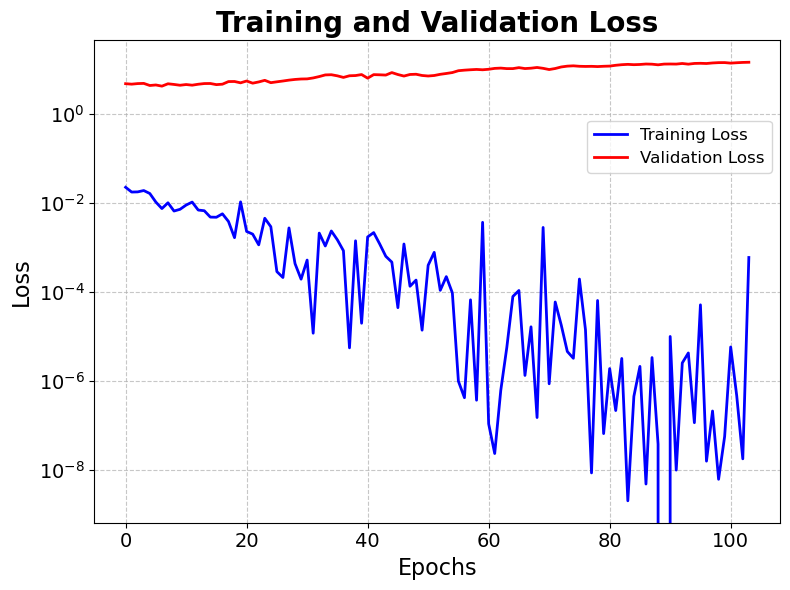

In [16]:
from matplotlib import pyplot as plt
import numpy as np

train_losses = np.load('finetuning/train_losses.npy')
val_losses = np.load('finetuning/val_losses.npy')

x_train = np.arange(0, len(train_losses))
x_val = np.arange(0, len(val_losses))

plt.figure(figsize=(8, 6))  # Adjust the figure size as desired

plt.plot(x_train, train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(x_val, val_losses, label='Validation Loss', color='red', linewidth=2)

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.yscale('log')

plt.title('Training and Validation Loss', fontsize=20, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.00, 0.85))  # Adjust the legend location and font size
plt.xticks(fontsize=14)  # Increase the tick font size on the x-axis
plt.yticks(fontsize=14)

plt.tight_layout()  # Improve spacing between subplots
plt.show()


# save train and validation losses
#np.save('train_losses.npy', train_losses)
#np.save('val_losses.npy', val_losses)

In [17]:
def summarize_array(array, interval=10):
    summary = "Array Summary:\n"
    summary += "Shape: {}\n".format(array.shape)
    summary += "Data Type: {}\n".format(array.dtype)
    summary += "Min Value: {}\n".format(np.min(array))
    summary += "Max Value: {}\n".format(np.max(array))
    summary += "Selected Values:\n"

    for i in range(0, len(array), interval):
        value = array[i]
        summary += "Index {}: {}\n".format(i, value)

    return summary

train_summary = summarize_array(train_losses)
val_summary = summarize_array(val_losses)

print("Train Losses Summary:")
print(train_summary)
print("Val Losses Summary:")
print(val_summary)

Train Losses Summary:
Array Summary:
Shape: (104,)
Data Type: float64
Min Value: 0.0
Max Value: 0.022542328168645525
Selected Values:
Index 0: 0.022542328168645525
Index 10: 0.008974432658230704
Index 20: 0.002287040516901552
Index 30: 0.0005191158081732247
Index 40: 0.0017204470633503713
Index 50: 0.0003962103115995661
Index 60: 1.0751081951433367e-07
Index 70: 8.552058856451457e-07
Index 80: 1.8780784920130619e-06
Index 90: 9.91435228386538e-06
Index 100: 5.756033939531738e-06

Val Losses Summary:
Array Summary:
Shape: (104,)
Data Type: float64
Min Value: 4.2498074549924505
Max Value: 14.641031413744196
Selected Values:
Index 0: 4.8253020758039495
Index 10: 4.618206740573743
Index 20: 5.546028201499682
Index 30: 6.1888855965524
Index 40: 6.425260820893951
Index 50: 7.184643688018211
Index 60: 10.179584281211106
Index 70: 10.039923559413866
Index 80: 12.006920993328094
Index 90: 13.377065265350893
Index 100: 14.001042576509724



In [ ]:
# Used to move the model to the CPU after training
model = model.to('cpu')
torch.cuda.empty_cache()


Print three correct and three incorrect predictions (you dont have to run this, it takes a bit of time).

tensor([[-242.4962, -175.4379, -192.9082, -215.8868, -290.5031, -184.6458,
         -176.7583, -323.8481, -350.0669, -260.5340, -372.9348, -255.2771,
         -321.7460, -217.1131, -270.4940, -252.6303, -196.0720, -240.1170,
         -223.7501, -315.0973, -273.1417, -227.3013, -289.6962, -299.6609,
         -208.0796, -238.8204, -364.2079, -216.3136, -318.1453, -239.6612,
         -188.6918, -264.1818, -160.2354, -324.5377, -328.1155, -211.4471,
         -367.3491, -309.5265, -295.1708, -340.2985, -211.0796, -265.7529,
         -331.9407, -313.7514, -281.5401, -324.5138, -335.8262, -209.5599,
         -282.0278, -278.9851, -192.2229, -276.9991, -289.9691, -239.2680,
         -249.3083, -197.5228, -168.5067, -203.6987, -342.0271, -239.1437,
         -266.2251, -195.5171, -279.8741, -321.1856, -291.1068, -300.6266,
         -300.0267, -327.8211, -214.1736, -362.5200, -305.1596, -260.9153,
         -327.6590, -199.4670, -302.9934, -232.5810, -313.8273, -347.8079,
         -225.0405, -269.

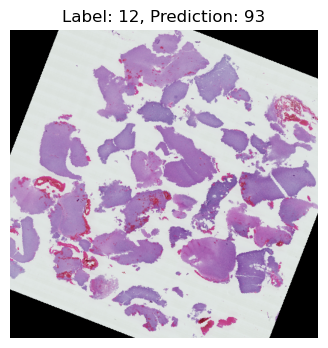

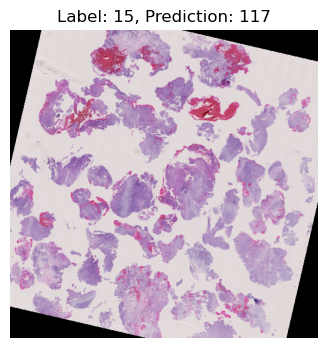

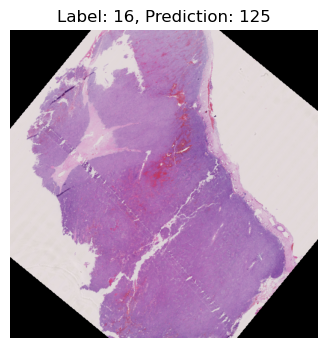

In [7]:
import matplotlib.pyplot as plt

model = model.to('cpu')

def plot_images(image, label, pred):
    plt.figure(figsize=(4, 4))
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    plt.imshow(image.numpy())
    plt.title(f'Label: {label}, Prediction: {pred}')
    plt.axis('off')
    plt.show()

def visualize_predictions(model, loader):
    model.eval()
    correct_imgs = []
    correct_labels = []
    correct_preds = []
    
    incorrect_imgs = []
    incorrect_labels = []
    incorrect_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            print(outputs)
            for i in range(len(labels)):
                if preds[i] == labels[i] and len(correct_imgs) < 3:
                    correct_imgs.append(images[i])
                    correct_labels.append(labels[i])
                    correct_preds.append(preds[i])
                elif preds[i] != labels[i] and len(incorrect_imgs) < 3:
                    incorrect_imgs.append(images[i])
                    incorrect_labels.append(labels[i])
                    incorrect_preds.append(preds[i])

            if len(correct_imgs) >= 3 or len(incorrect_imgs) >= 3:
                break

    #print("Correct Predictions:")
    #for i in range(3):
    #    plot_images(correct_imgs[i], correct_labels[i], correct_preds[i])

    print("Incorrect Predictions:")
    for i in range(3):
        plot_images(incorrect_imgs[i], incorrect_labels[i], incorrect_preds[i])

# Assume `model` is your trained model and `loader` is your validation dataloader
visualize_predictions(model, val_loader)


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Move the model to the device
#model.to(device)

# Set the model to evaluate mode
#model.eval()

def calc_preds(loader):

    true_labels = []
    pred_labels = []

    # Iterate over the validation data
    for images, labels in loader:
        # Move the images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Store the true and predicted labels for this batch
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

    return true_labels, pred_labels

true_labels, pred_labels = calc_preds(train_loader)
val_true_labels, val_pred_labels = calc_preds(val_loader)

C:\Users\Kontor\AppData\Local\Temp\ipykernel_25028\4017621957.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


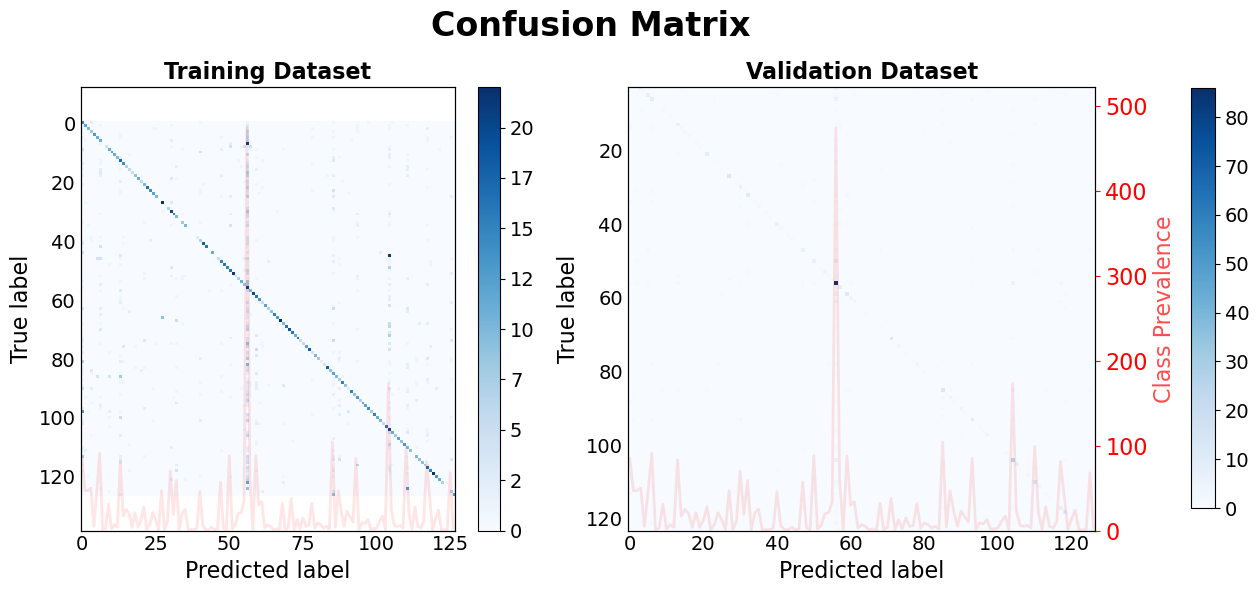

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter

# Assuming true_labels, pred_labels, val_true_labels, and val_pred_labels are your arrays of length 363
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
val_true_labels = np.array(val_true_labels)
val_pred_labels = np.array(val_pred_labels)

# Create a confusion matrix for the training dataset
cm_train = confusion_matrix(true_labels, pred_labels, labels=np.arange(output_dim))

# Create a confusion matrix for the validation dataset
cm_val = confusion_matrix(val_true_labels, val_pred_labels, labels=np.arange(output_dim))

# Determine the maximum value between the training and validation confusion matrices
max_train = np.max(cm_train)
max_val = np.max(cm_val)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the confusion matrix for the training dataset
im_train = axes[0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=max_train)
axes[0].set_title('Training Dataset', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted label', fontsize=16)
axes[0].set_ylabel('True label', fontsize=16)
axes[0].tick_params(axis='both', which='both', length=0, labelsize=14)

# Add a color bar for the training plot
cbar_train = fig.colorbar(im_train, ax=axes[0], format='%d', cmap=plt.cm.Blues)
cbar_train.ax.tick_params(labelsize=14)

# Plot the confusion matrix for the validation dataset
im_val = axes[1].imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=max_val)
axes[1].set_title('Validation Dataset', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Predicted label', fontsize=16)
axes[1].set_ylabel('True label', fontsize=16)
axes[1].tick_params(axis='both', which='both', length=0, labelsize=14)

# Retrieve class labels and their counts from the Counter object
class_labels = dataset.class_samples.keys()
class_counts = dataset.class_samples.values()

ax1 = axes[0].twinx()
ax1.plot(class_labels, class_counts, color='r', linestyle='-', linewidth=2, alpha=0.1)
ax1.set_ylim(0, max(class_counts) * 1.1)
ax1.yaxis.set_ticks([])


ax2 = axes[1].twinx()
ax2.plot(class_labels, class_counts, color='r', linestyle='-', linewidth=2, alpha=0.1)
ax2.set_ylabel('Class Prevalence', fontsize=16, color='r', alpha=0.7)
ax2.tick_params(axis='y', labelsize=16, colors='r')
ax2.set_ylim(0, max(class_counts) * 1.1)

# Add a color bar for the validation plot
cbar_val_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar_val = fig.colorbar(im_val, cax=cbar_val_ax, format='%d', cmap=plt.cm.Blues)
cbar_val.ax.tick_params(labelsize=14)

# Add a suptitle with the common title for both subplots
fig.suptitle('Confusion Matrix', fontsize=24, fontweight='bold')

plt.tight_layout()
plt.show()


In [100]:
print(len(train_loader)*4)
print(len(val_loader)*4)

3116
624


In [61]:
print(len(np.unique(np.concatenate((true_labels, pred_labels)))))

119


In [59]:
# Calculate the counts of each label in the training set predictions
train_label_counts = Counter(pred_labels)

# Calculate the counts of each label in the validation set predictions
val_label_counts = Counter(val_pred_labels)

# Find the label with the most predictions in the training set
most_common_train_label = train_label_counts.most_common(1)[0][0]

# Find the label with the most predictions in the validation set
most_common_val_label = val_label_counts.most_common(1)[0][0]

print("Label with the most predictions in the training set:", most_common_train_label)
print("Label with the most predictions in the validation set:", most_common_val_label)

Label with the most predictions in the training set: 56
Label with the most predictions in the validation set: 56


# Interpretability

In [3]:
# Get new dataset without rotations
train_loader, val_loader, dataset = loadAndPrepareData(root_dir, batch_size=4, n_classes=127, augment=False, shuffle=False)

Counter({56: 474, 104: 173, 85: 104, 110: 99, 6: 91, 50: 88, 59: 88, 0: 85, 93: 85, 13: 83, 117: 81, 30: 70, 125: 68, 32: 59, 57: 59, 47: 57, 3: 50, 1: 47, 2: 47, 27: 47, 87: 47, 5: 46, 40: 46, 118: 41, 71: 38, 55: 34, 61: 34, 68: 32, 78: 32, 9: 31, 60: 30, 21: 28, 113: 28, 15: 25, 35: 25, 105: 24, 121: 24, 88: 23, 90: 23, 18: 21, 24: 21, 34: 21, 54: 21, 111: 21, 16: 20, 53: 20, 31: 19, 14: 17, 102: 17, 91: 16, 75: 15, 120: 14, 25: 13, 73: 13, 97: 13, 20: 12, 29: 11, 101: 11, 116: 11, 92: 10, 80: 9, 95: 9, 96: 8, 11: 7, 23: 7, 63: 7, 81: 7, 41: 6, 52: 6, 77: 6, 106: 6, 108: 6, 4: 5, 64: 5, 76: 5, 83: 5, 89: 5, 107: 5, 114: 5, 12: 4, 17: 4, 19: 4, 44: 4, 70: 4, 86: 4, 8: 3, 39: 3, 48: 3, 62: 3, 79: 3, 82: 3, 100: 3, 109: 3, 115: 3, 10: 2, 46: 2, 51: 2, 66: 2, 74: 2, 84: 2, 98: 2, 99: 2, 7: 1, 22: 1, 26: 1, 28: 1, 33: 1, 36: 1, 37: 1, 38: 1, 42: 1, 43: 1, 45: 1, 49: 1, 58: 1, 65: 1, 67: 1, 69: 1, 72: 1, 94: 1, 103: 1, 112: 1, 119: 1, 122: 1, 123: 1, 124: 1, 126: 1})


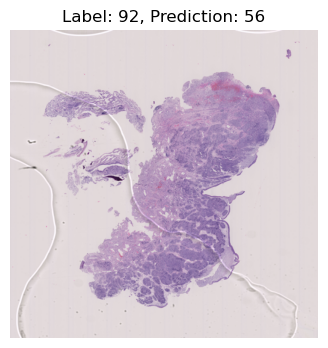

In [42]:
import matplotlib.pyplot as plt

model = model.to('cpu')

def plot_image(image, label, pred):
    plt.figure(figsize=(4, 4))
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    image = image * std + mean
    plt.imshow(image.numpy())
    plt.title(f'Label: {label}, Prediction: {pred}')
    plt.axis('off')
    plt.show()

def visualize_predictions(model, loader):
    model.eval()
    
    with torch.no_grad():
        images, labels = next(iter(loader))
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        plot_image(images[0], labels[0], preds[0])

# Assume `model` is your trained model and `loader` is your validation dataloader
visualize_predictions(model, train_loader)


# Get Top-10 predictions

In [64]:
# Get image and label
images, labels = iter(train_loader).next()
input_tensor = images[0].unsqueeze(0)
target_label = labels[0].unsqueeze(0)

def get_top_probs(model, input_tensor, top_n=10):
	model.eval()

	output = model(input_tensor)  # unsqueeze single image into batch of 1
	top_probs, top_class_indices = torch.topk(output.softmax(dim=1), k=top_n)
	predictions = [(dataset.tumor_type_dict[idx], top_probs[0][i].item()) for i, idx in enumerate(top_class_indices[0].tolist())]

	return predictions

get_top_probs(model, input_tensor)

[('Glioblastoma, IDH-wildtype', 0.7944298982620239),
 ('Medulloblastoma, non-WNT-non-SHH', 0.14187055826187134),
 ('Meningothelial meningioma', 0.0461236797273159),
 ('Adamantinomatous craniopharyngioma', 0.01438305713236332),
 ('Anaplastic ependymoma', 0.002362073864787817),
 ('Choroid plexus papilloma', 0.0003507455694489181),
 ('Anaplastic oligodendroglioma, IDH-mutant and 1p-19q codeleted',
  0.00033779029035940766),
 ('Atypical teratoid-rhabdoid tumour', 6.491408566944301e-05),
 ('Atypical meningioma', 3.3129079383797944e-05),
 ('Haemangioblastoma', 1.6487652828800492e-05)]

In [84]:
print(dataset.tumor_type_dict)

{0: 'Adamantinomatous craniopharyngioma', 1: 'Anaplastic astrocytoma, IDH-mutant', 2: 'Anaplastic astrocytoma, IDH-wildtype', 3: 'Anaplastic ependymoma', 4: 'Anaplastic ganglioglioma', 5: 'Anaplastic meningioma', 6: 'Anaplastic oligodendroglioma, IDH-mutant and 1p-19q codeleted', 7: 'Anaplastic pleomorphic xanthoastrocytoma', 8: 'Angiocentric glioma', 9: 'Angiomatous meningioma', 10: 'Angiosarcoma', 11: 'Astroblastoma', 12: 'Atypical choroid plexus papilloma', 13: 'Atypical meningioma', 14: 'Atypical teratoid-rhabdoid tumour', 15: 'Cellular schwannoma', 16: 'Central neurocytoma', 17: 'Cerebellar liponeurocytoma', 18: 'Chondrosarcoma', 19: 'Chordoid glioma of the third ventricle', 20: 'Chordoid meningioma', 21: 'Chordoma', 22: 'Choriocarcinoma', 23: 'Choroid plexus carcinoma', 24: 'Choroid plexus papilloma', 25: 'Clear cell meningioma', 26: 'CNS ganglioneuroblastoma', 27: 'Control', 28: 'Crystal-storing histiocytosis', 29: 'Desmoplastic infantile astrocytoma and ganglioglioma', 30: 'Dif

# Grad-CAM

We are using the python library *grad-cam* for this: https://github.com/jacobgil/pytorch-grad-cam

In [82]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.metrics.road import ROADCombined

# Get image and label
images, labels = iter(train_loader).next()
input_tensor = images[3].unsqueeze(0)
target_label = labels[3].unsqueeze(0)

def calcGradCAM(model, input_tensor, target_label):
	# In VGG, feature part is called 'features', the last layer is [-1]
	target_layers = [model.features[-1]]

	cam = GradCAM(model=model, target_layers=target_layers)

	targets = [ClassifierOutputTarget(target_label.item())]

	grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

	# Conver to 8-bit (range 0-255)
	grayscale_cam_8bit = np.squeeze(np.uint8(255 * grayscale_cam))

	# Convert the tensor image to numpy array, transpose from CxHxW to HxWxC format, and 
	# reverse normalize using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
	rgb_img = np.clip(input_tensor.squeeze().permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

	visualization = show_cam_on_image(rgb_img, grayscale_cam_8bit)

	# Calculate metrics
	cam_metric = CamMultImageConfidenceChange()
	scores, batch_visualizations = cam_metric(input_tensor, 
		grayscale_cam, 
		[ClassifierOutputTarget(target_label.item())], 
		model, 
		return_visualization=True)

	cam_metric_road = ROADCombined(percentiles=[20, 40, 60, 80])
	scores_road = cam_metric_road(input_tensor, 
		grayscale_cam, 
		[ClassifierOutputTarget(target_label.item())], 
		model)

	# Print scores
	print(f'CamMultImageConfidenceChange Score: {scores[0]}')
	print(f'ROAD Score: {scores_road[0]}')

	return rgb_img, visualization, batch_visualizations

rgb_img, visualization, batch_visualizations = calcGradCAM(model, input_tensor, target_label)

CamMultImageConfidenceChange Score: 69.49657440185547
ROAD Score: -11.660886764526367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


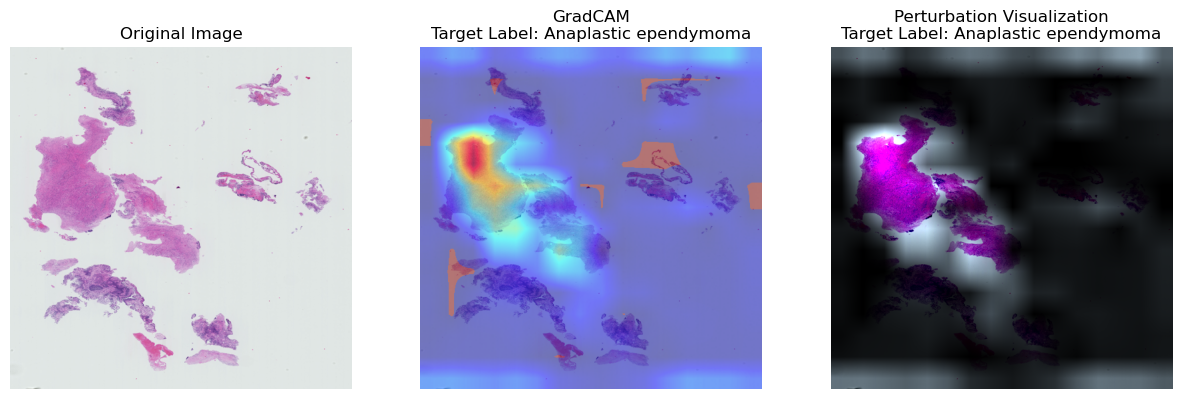

In [83]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Show original image
axs[0].imshow(rgb_img)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Show visualization on the right
axs[1].imshow(visualization)
axs[1].set_title(f"GradCAM\nTarget Label: {dataset.tumor_type_dict[target_label.item()]}")
axs[1].axis('off')

# Show perturbation visualizations on the right
axs[2].imshow(batch_visualizations[0].permute(1, 2, 0))
axs[2].set_title(f"Perturbation Visualization\nTarget Label: {dataset.tumor_type_dict[target_label.item()]}")
axs[2].axis('off')

plt.show()

In [ ]:
'''model.eval()

img, labels = next(iter(train_loader))

output = model(img)
print(output.shape)

# Compute the maximum predicted class and its corresponding output value
_, predicted_class = torch.max(output, 1)
output_max = output[0, predicted_class]

# Compute the gradient of output_max with respect to the parameters of the model
model.zero_grad()
output_max.backward()

# Compute the saliency map
saliency, _ = torch.max(model.conv1.weight.grad.abs(), dim=1)
saliency = saliency.reshape((3, 224, 224))

# Visualize the saliency map
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
plt.imshow(saliency.cpu().detach().numpy(), cmap='hot')
plt.show()'''